In [1]:
import os
os.chdir('../..')
os.getcwd()

'H:\\StockMaster'

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

from sklearn.preprocessing import MinMaxScaler

In [1]:
import pandas_datareader as pdr
df= pdr.get_data_yahoo('AAPL', '2000-01-01')

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1999-12-31,3.674107,3.553571,3.604911,3.671875,40952800.0,3.178732
2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,3.460857
2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,3.169071
2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,3.215448
2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.937188
...,...,...,...,...,...,...
2020-07-27,379.619995,373.920013,374.839996,379.239990,30303500.0,379.239990
2020-07-28,378.200012,372.989990,377.470001,373.010010,25906400.0,373.010010
2020-07-29,380.920013,374.850006,375.000000,380.160004,22582300.0,380.160004


In [4]:
# log 정규화
def nplog(dataframe):
    
    temp = np.log(dataframe)
    
    return temp

# indicator 계산
def get_indicators(dataframe, *indicators):
    
    from Indicator import get_Bolinger_Band
    from Indicator import get_DMI
    from Indicator import get_MACD
    from Indicator import get_RSI
    
    

    BAND = get_Bolinger_Band.fnBolingerBand
    DMI = get_DMI.cal_dmi
    MACD = get_MACD.fnMACD
    RSI = get_RSI.fnRSI
    
    
    for indicator in indicators:
        
        if indicator == 'DMI':
            DMI(dataframe)
        elif indicator == 'MACD':
            MACD(dataframe)
        elif indicator == 'RSI':
            RSI(dataframe)
        elif indicator == 'BAND':
            BAND(dataframe)
    
    dataframe.dropna(inplace=True)
    
    return dataframe

# minmax scale
def make_sc_col_df(train_scdf):
    for i in train_scdf.columns:
        globals()['scaler_{}'.format(i)] = MinMaxScaler()
        print("df_{}".format(i))
        globals()["df_{}".format(i)] = train_scdf[[i]]
        globals()["df_{}".format(i)] = globals()['scaler_{}'.format(i)].fit_transform(globals()["df_{}".format(i)])
        globals()["df_{}".format(i)] = pd.DataFrame(globals()["df_{}".format(i)])
        globals()["df_{}".format(i)].index = train_scdf.index
        globals()["df_{}".format(i)].columns = [i]

    return globals()["df_{}".format(i)]

# shift data
def shift_df(*dataframes, start=1, end=11):  
    shift_num = end
    for dataframe in dataframes:
        for s in range(start, end):
            dataframe['shift_{}'.format(s)] = dataframe[dataframe.columns[0]].shift(s)
        dataframe.dropna(inplace=True)
    return dataframe

# concat dataframe
def df_concat(*dataframes):
    all_Df =  pd.concat([*dataframes], axis=1)
    all_Df.dropna(inplace=True)
    return all_Df

# drop original values
def drop_ori_cols(all_df):
    col_list = []
    for i in all_df.columns:
        if 'shift' in i:
            pass
        elif 'Close' in i:
            pass
        else:
            col_list.append(i)
    all_df.drop(col_list, axis=1, inplace=True)
    
    return all_df

# set y target & split train test
def set_split(all_df, num=1, xnum=200):
    xdata = all_df.drop('Close', axis=1)[:-num]
    ydata = all_df['Close'][num:].values
    
    x_train = xdata[:-xnum]
    x_test = xdata[-xnum:]

    ytrain = ydata[:-xnum]
    ytest = ydata[-xnum:]
    
    shift_num = 10
    x_train = np.array(x_train).reshape(len(x_train), int(len(x_train.columns)/shift_num), shift_num)
    x_test = np.array(x_test).reshape(len(x_test), int(len(x_test.columns)/shift_num), shift_num)

    
    return x_train, x_test, ytrain, ytest

# make LSTM model
def LSTMmodel():
    from tensorflow.keras.layers import LSTM 
    from tensorflow.keras.models import Sequential 
    from tensorflow.keras.layers import Dense 
    import tensorflow.keras.backend as K 
    from tensorflow.keras.callbacks import EarlyStopping


    model = Sequential() # Sequeatial Model 
    model.add(LSTM(20, input_shape=(x_train.shape[1], x_train.shape[2]))) # (timestep, feature) 
    
    model.add(Dense(1)) # output = 1 
    model.compile(loss='mean_squared_error', optimizer='adam') 
    model.summary()
    
    return model

# inverse predict 
def get_real(pred, scaler_Close):
    
    real = np.exp(scaler_Close.inverse_transform(pred))
    real = pd.DataFrame(real, columns = pred.columns)
    real['err'] = real['real'] - real['pred']
    
    return real

# model save
def save(model, name):
    # 전체 모델을 HDF5 파일로 저장합니다
    model.save('./src/parkjunsung/models/' + str(name) + '.h5')
    
# shift close
def future_stock(dataframe):
    for s in range(1, 2):
        dataframe['shift_{}'.format(s)] = dataframe[dataframe.columns[0]].shift(s)
    return dataframe

In [5]:
log_df = nplog(df)
indicators = get_indicators(log_df, 'DMI', 'RSI', 'MACD', 'BAND')
make_sc_col_df(indicators)

df_High
df_Low
df_Open
df_Close
df_Volume
df_Adj Close
df_PDI
df_MDI
df_ADX
df_RSI_MACD
df_EMAFast
df_EMASlow
df_MACD
df_MACDSignal
df_MACDDiff
df_20d_ma
df_Bol_upper
df_Bol_lower


,Bol_lower
Date,
2000-02-17,0.239415
2000-02-18,0.239414
2000-02-22,0.239925
2000-02-23,0.239784
2000-02-24,0.239838
...,...
2020-07-27,0.997045
2020-07-28,0.997931
2020-07-29,0.998837


In [6]:
shift_df(df_High,
df_Low,
df_Open,
df_Close,
df_Volume,
df_PDI,
df_MDI,
df_ADX,
df_RSI_MACD,
df_EMAFast,
df_EMASlow,
df_MACD,
df_MACDSignal,
df_MACDDiff,
df_20d_ma,
df_Bol_upper,
df_Bol_lower
)

,Bol_lower,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10
Date,,,,,,,,,,,
2000-03-03,0.249678,0.248061,0.243902,0.243331,0.241841,0.239867,0.239838,0.239784,0.239925,0.239414,0.239415
2000-03-06,0.250609,0.249678,0.248061,0.243902,0.243331,0.241841,0.239867,0.239838,0.239784,0.239925,0.239414
2000-03-07,0.250799,0.250609,0.249678,0.248061,0.243902,0.243331,0.241841,0.239867,0.239838,0.239784,0.239925
2000-03-08,0.251030,0.250799,0.250609,0.249678,0.248061,0.243902,0.243331,0.241841,0.239867,0.239838,0.239784
2000-03-09,0.251695,0.251030,0.250799,0.250609,0.249678,0.248061,0.243902,0.243331,0.241841,0.239867,0.239838
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,0.997045,0.995146,0.994805,0.994058,0.993724,0.992935,0.991684,0.990613,0.989772,0.989460,0.988411
2020-07-28,0.997931,0.997045,0.995146,0.994805,0.994058,0.993724,0.992935,0.991684,0.990613,0.989772,0.989460
2020-07-29,0.998837,0.997931,0.997045,0.995146,0.994805,0.994058,0.993724,0.992935,0.991684,0.990613,0.989772


In [7]:
all_df = df_concat(df_High,
df_Low,
df_Open,
df_Close,
df_Volume,
df_PDI,
df_MDI,
df_ADX,
df_RSI_MACD,
df_EMAFast,
df_EMASlow,
df_MACD,
df_MACDSignal,
df_MACDDiff,
df_20d_ma,
df_Bol_upper,
df_Bol_lower)

drop_ori_cols(all_df)

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,...,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-03,0.258281,0.263472,0.244012,0.240842,0.243663,0.246607,0.246435,0.243575,0.241375,0.241552,...,0.248061,0.243902,0.243331,0.241841,0.239867,0.239838,0.239784,0.239925,0.239414,0.239415
2000-03-06,0.258660,0.258281,0.263472,0.244012,0.240842,0.243663,0.246607,0.246435,0.243575,0.241375,...,0.249678,0.248061,0.243902,0.243331,0.241841,0.239867,0.239838,0.239784,0.239925,0.239414
2000-03-07,0.259793,0.258660,0.258281,0.263472,0.244012,0.240842,0.243663,0.246607,0.246435,0.243575,...,0.250609,0.249678,0.248061,0.243902,0.243331,0.241841,0.239867,0.239838,0.239784,0.239925
2000-03-08,0.257641,0.259793,0.258660,0.258281,0.263472,0.244012,0.240842,0.243663,0.246607,0.246435,...,0.250799,0.250609,0.249678,0.248061,0.243902,0.243331,0.241841,0.239867,0.239838,0.239784
2000-03-09,0.253085,0.257641,0.259793,0.258660,0.258281,0.263472,0.244012,0.240842,0.243663,0.246607,...,0.251030,0.250799,0.250609,0.249678,0.248061,0.243902,0.243331,0.241841,0.239867,0.239838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,0.977905,0.984977,0.986483,0.988598,0.987357,0.985095,0.985528,0.988594,0.985276,0.989756,...,0.995146,0.994805,0.994058,0.993724,0.992935,0.991684,0.990613,0.989772,0.989460,0.988411
2020-07-28,0.981275,0.977905,0.984977,0.986483,0.988598,0.987357,0.985095,0.985528,0.988594,0.985276,...,0.997045,0.995146,0.994805,0.994058,0.993724,0.992935,0.991684,0.990613,0.989772,0.989460
2020-07-29,0.980662,0.981275,0.977905,0.984977,0.986483,0.988598,0.987357,0.985095,0.985528,0.988594,...,0.997931,0.997045,0.995146,0.994805,0.994058,0.993724,0.992935,0.991684,0.990613,0.989772


In [153]:
x_train, x_test, y_train, y_test = set_split(all_df)

In [154]:
model = LSTMmodel()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
Total params: 3,301
Trainable params: 3,301
Non-trainable params: 0
_________________________________________________________________


In [155]:
model.fit(x_train, y_train, epochs=10, batch_size=10, verbose=1)

Epoch 1/10
4890/4890 [==============================] - 5s 938us/sample - loss: 0.0086
Epoch 2/10
4890/4890 [==============================] - 4s 788us/sample - loss: 2.2909e-04
Epoch 3/10
4890/4890 [==============================] - 4s 886us/sample - loss: 1.9114e-04
Epoch 4/10
4890/4890 [==============================] - 5s 951us/sample - loss: 1.7265e-04
Epoch 5/10
4890/4890 [==============================] - 5s 994us/sample - loss: 1.6306e-04
Epoch 6/10
4890/4890 [==============================] - 5s 1ms/sample - loss: 1.5084e-04
Epoch 7/10
4890/4890 [==============================] - 5s 1ms/sample - loss: 1.3139e-04
Epoch 8/10
4890/4890 [==============================] - 5s 1ms/sample - loss: 1.3648e-04
Epoch 9/10
4890/4890 [==============================] - 6s 1ms/sample - loss: 1.4062e-04
Epoch 10/10
4890/4890 [==============================] - 5s 1ms/sample - loss: 1.1968e-04


In [156]:
pred = pd.DataFrame(model.predict(x_test), columns = ['pred'])

In [157]:
pred['real'] = y_test

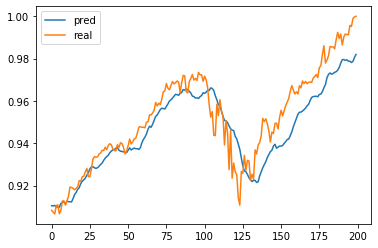

In [158]:
pred.plot()

In [129]:
pred['err'] = pred['pred'] - pred['real']

In [130]:
pred.describe()

,pred,real,err
count,200.000000,200.000000,200.000000
mean,0.946708,0.951186,-0.004478
std,0.020638,0.022617,0.007222
min,0.902934,0.906636,-0.018025
25%,0.932580,0.935283,-0.008823
50%,0.947206,0.951159,-0.005463
75%,0.962323,0.968775,-0.001930
max,0.993001,1.000000,0.023976


In [131]:
get_real(pred[['pred', 'real']], scaler_Close)

,pred,real,err
0,214.000948,221.029999,7.029051
1,214.442162,219.889999,5.447837
2,215.506336,218.820007,3.313672
3,217.338582,223.970001,6.631419
4,214.556127,224.589996,10.033870
...,...,...,...
195,351.975037,373.850006,21.874969
196,353.667069,372.690002,19.022933
197,361.602687,381.369995,19.767308
198,365.760129,383.010010,17.249881


In [132]:
save(model, 'stock_master2')

In [66]:
sc_test = scaler_Close.transform(logg)

In [67]:
sc_test = sc_test.reshape(1, sc_test.shape[0], sc_test.shape[1])

In [68]:
sc_test

array([[[1.        , 0.99970943]]])

In [73]:
model.predict(sc_test)

array([[1.0028166]], dtype=float32)

In [74]:
real = np.exp(scaler_Close.inverse_transform(new_model.predict(sc_test)))
real

array([[390.2352]], dtype=float32)

In [78]:
pred_future = pd.DataFrame(real, columns=['pred'], index=['2020-07-13'])

In [10]:
new_model = load_model('./src/parkjunsung/models/stock_master.h5')
new_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1840      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
________________

In [26]:
pred1 = pd.DataFrame(new_model.predict(x_test), columns = ['pred'])
pred1['real'] = y_test

In [28]:
get_real(pred1[['pred', 'real']], scaler_Close)

,pred,real,err
0,227.866230,221.029999,-6.836231
1,227.792230,219.889999,-7.902230
2,229.056220,218.820007,-10.236213
3,230.067759,223.970001,-6.097758
4,228.955812,224.589996,-4.365816
...,...,...,...
195,372.006258,373.850006,1.843748
196,371.690713,372.690002,0.999289
197,376.606266,381.369995,4.763730
198,380.496031,383.010010,2.513979
